# Introduzione

Questo progetto mira a condurre un’analisi approfondita del dataset Breast Cancer Wisconsin (Diagnostic), derivato dallo studio di Street, Wolberg e Mangasarian (1993).
Il dataset contiene misurazioni morfologiche e di texture dei nuclei cellulari ottenute da immagini digitali di aspirazioni con ago sottile di tessuto mammario.
L’obiettivo principale è applicare tecniche di data mining e machine learning per classificare accuratamente i campioni come benigni o maligni, sulla base delle caratteristiche estratte dalle immagini.

Le feature rappresentano parametri geometrici e strutturali dei nuclei, tra cui:
	•	dimensione (raggio, area, perimetro),
	•	forma (compattezza, concavità, simmetria, dimensione frattale),
	•	texture (varianza di intensità dei pixel).

Ogni immagine è descritta da 30 variabili numeriche, derivate da 10 misure di base (media, deviazione standard ed estremo superiore per ciascuna).
L’analisi esplorativa si concentrerà sull’identificazione delle relazioni tra queste feature e sulla loro capacità di discriminare tra tessuti benigni e maligni, con l’obiettivo finale di sviluppare un modello predittivo robusto e interpretabile.



In [102]:
# =======================
# Librerie per gestione dati e visualizzazione
# =======================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import parallel_coordinates

# =======================
# Caricamento dataset (OpenML)
# =======================
from sklearn.datasets import fetch_openml

# =======================
# Preprocessing, feature selection e riduzione dimensionale
# =======================
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, RFE, mutual_info_classif
from sklearn.decomposition import PCA

# =======================
# Modelli di classificazione
# =======================
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# =======================
# Validazione, metriche e tuning
# =======================
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

# =======================
# Utility per plotting e supporto
# =======================
import math
from sklearn.base import clone
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import random


In [103]:
# Costanti globali per garantire riproducibilità e configurabilità
RANDOM_STATE = 42  # Per riproducibilità dei risultati
TEST_SIZE = 0.2    # 20% dei dati per il test set
CV_FOLDS = 5       # 5-fold cross validation

In [104]:
# Seme per il generatore di Python
random.seed(RANDOM_STATE)

# Seme per NumPy (usato internamente da molte funzioni di sklearn)
np.random.seed(RANDOM_STATE)

In [105]:
# =======================
# ANALISI ESPLORATIVA (EDA)
# =======================

# Caricamento del dataset WDBC (OpenML ID: 1510)
try:
    data_bunch = fetch_openml(data_id=1510, as_frame=True, parser='auto')
except Exception as e:
    print(f"Errore nel caricamento dati: {e}")

df = data_bunch.frame


# =======================
# Identificazione della colonna target
# =======================
class_column_name = data_bunch.target_names[0]
print(f"Identificata la colonna target: '{class_column_name}'")


# =======================
# Gestione e verifica dei nomi delle feature
# =======================
# Alcuni dataset OpenML usano nomi generici (V1, V2, ...)
if df.columns.str.startswith('V').any():
    # Assegna i nomi corretti alle feature secondo la documentazione del dataset
    feature_column_names = [
        'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
        'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
        'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
        'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
        'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
        'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
    ]
    df.columns = feature_column_names + [class_column_name]
else:
    feature_column_names = data_bunch.feature_names
    print("Nomi delle colonne già corretti.")


# =======================
# Analisi preliminare del dataset
# =======================
print("\n--- Prime 5 righe del DataFrame Combinato ---")
print(df.head())

print("\n--- Informazioni (Tipi di dati e Valori Mancanti) ---")
df.info()


Identificata la colonna target: 'Class'

--- Prime 5 righe del DataFrame Combinato ---
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fr

In [106]:
# =======================
# Controllo dimensioni iniziali del dataset
# =======================
print(f"Shape iniziale: {df.shape}")


# =======================
# Gestione dei valori mancanti
# =======================
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"Valori mancanti:\n{missing[missing > 0]}")
    df = df.dropna()
else:
    print("Nessun valore mancante")


# =======================
# Rimozione feature a varianza nulla o molto bassa
# =======================
# Elimina feature che non apportano informazione discriminante

X_temp = df.drop(class_column_name, axis=1)
var_selector = VarianceThreshold(threshold=0.00)
var_selector.fit(X_temp)

low_var_features = X_temp.columns[~var_selector.get_support()].tolist()
if low_var_features:
    print(f"Feature a bassa varianza rimosse: {low_var_features}")
    print(f"Numero di feature a bassa varianza rimosse: {len(low_var_features)}")
    df = df.drop(columns=low_var_features)
else:
    print("Nessuna feature a bassa varianza")


# =======================
# Aggiornamento lista delle feature
# =======================
feature_column_names = df.drop(columns=[class_column_name]).columns.tolist()


Shape iniziale: (569, 31)
Nessun valore mancante
Nessuna feature a bassa varianza


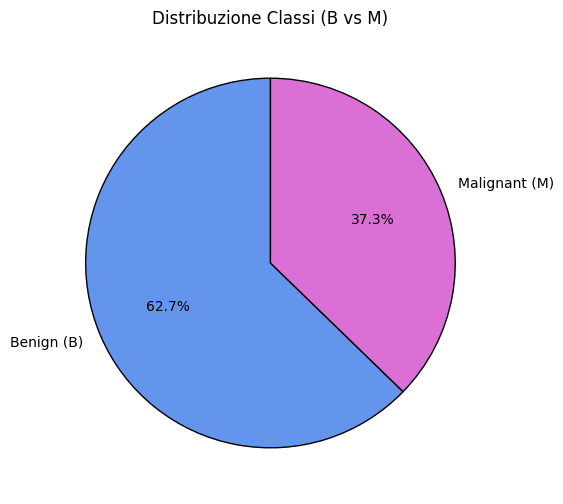

In [107]:
# =======================
# Visualizzazione della distribuzione delle classi (grafico a torta)
# =======================

# Mappatura delle classi e colori associati
class_map = {'1': 'Benign (B)', '2': 'Malignant (M)'}
color_map_dict = {'Benign (B)': 'cornflowerblue', 'Malignant (M)': 'orchid'}

# Preparazione del DataFrame per la visualizzazione
df_plot = df.copy()
df_plot['Diagnosis_Label'] = df[class_column_name].map(class_map)
df_plot = df_plot.drop(columns=[class_column_name])

# Creazione del grafico a torta
plt.figure(figsize=(6, 6))

# Conteggio delle classi
counts = df_plot['Diagnosis_Label'].value_counts()

# Assegnazione colori in base all’ordine delle etichette
colors = [color_map_dict[label] for label in counts.index]

counts.plot.pie(
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'edgecolor': 'black'},
    startangle=90
)

plt.title('Distribuzione Classi (B vs M)')
plt.ylabel('')
plt.show()


Il dataset presenta un bilanciamento ragionevole tra le due classi, con 357 campioni benigni (classe 1) e 212 maligni (classe 2), corrispondente a un rapporto di circa 1.68:1. Questa proporzione riflette la distribuzione clinica reale, dove i tumori benigni sono più comuni di quelli maligni. 

Il leggero sbilanciamento non è critico (non supera il rapporto 2:1), ma sarà importante considerarlo nella valutazione dei modelli, privilegiando metriche come F1-score e usando tecniche come StratifiedKFold per garantire rappresentatività delle classi in ogni fold della cross-validation.

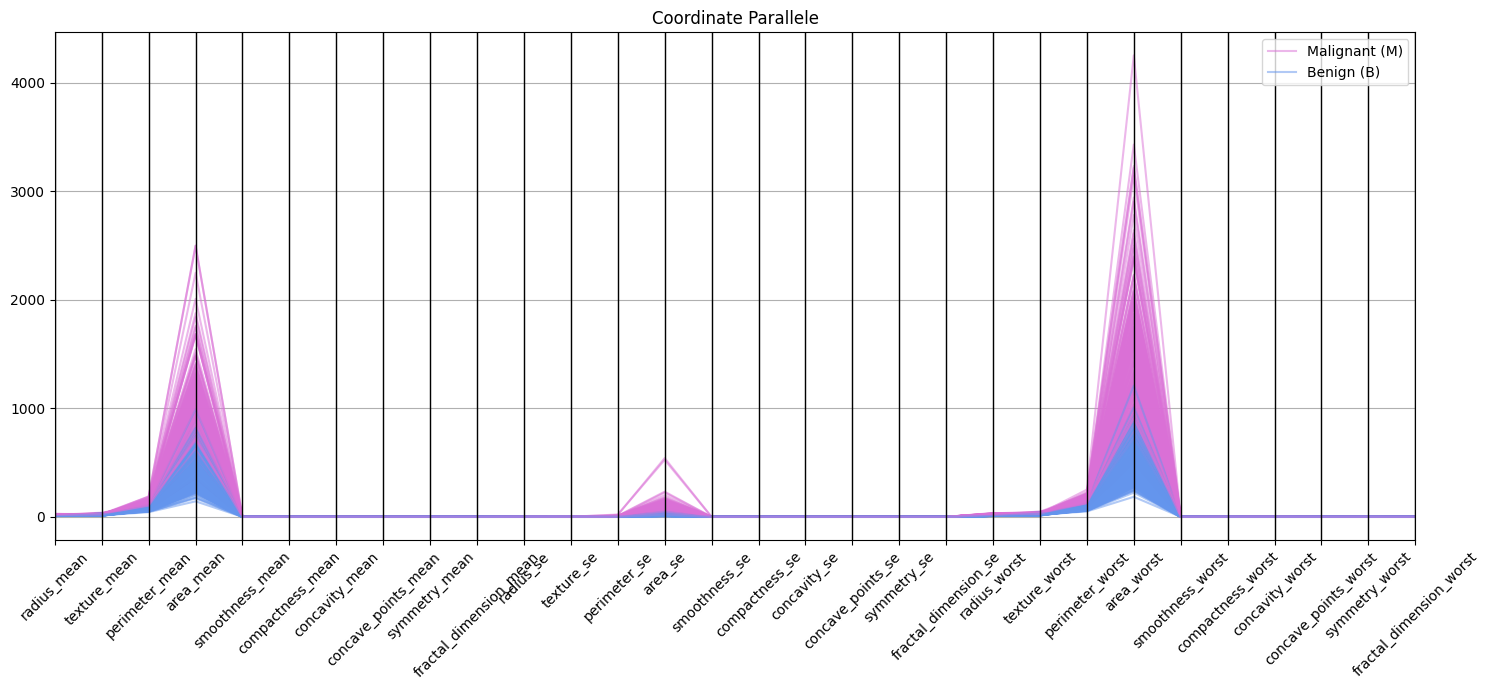

In [108]:
# =======================
# Visualizzazione delle coordinate parallele (feature non scalate)
# =======================
plt.figure(figsize=(15, 7))

parallel_coordinates(
    df_plot,
    'Diagnosis_Label',
    color=['orchid', 'cornflowerblue'],
    alpha=0.5
)

plt.title('Coordinate Parallele')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Il grafico a coordinate parallele consente di osservare simultaneamente l’andamento delle diverse feature del dataset WDBC confrontando i campioni benigni e maligni. Ogni linea rappresenta un singolo campione, mentre ogni asse verticale corrisponde a una variabile diagnostica. La presenza di due gruppi di linee (viola per i tumori maligni e blu per quelli benigni) permette di identificare visivamente quali feature differenziano maggiormente le due classi.

Dalla visualizzazione emerge che molte delle variabili legate alle dimensioni fisiche del tumore (come radius, perimeter, area e le loro varianti worst) assumono valori significativamente più elevati nei campioni maligni. Questo si traduce in un cluster di linee viola posizionate più in alto lungo questi assi, mentre i campioni benigni mostrano valori generalmente più contenuti e distribuzioni più compatte. Analogamente, le feature che descrivono irregolarità del profilo, come concavity e concave points, presentano differenze marcate tra le due classi, con i maligni che tendono a valori più alti.

Alcune caratteristiche, come smoothness, symmetry e fractal_dimension, mostrano invece una forte sovrapposizione dei due gruppi. Questo suggerisce che, se considerate singolarmente, possiedono un potere discriminante più limitato rispetto alle variabili geometriche principali.

Nel complesso, il grafico mette in evidenza che i tumori maligni si distinguono per dimensioni maggiori e maggiore irregolarità dei contorni. Questa separazione visiva conferma quali feature risultano più informative per i modelli di classificazione e contribuisce a comprendere meglio la struttura interna del dataset prima della fase di modellazione.


Le distribuzioni delle prime dodici feature evidenziano con chiarezza le differenze strutturali tra i campioni benigni e maligni del dataset WDBC. Nelle variabili che descrivono dimensioni e grandezza del tumore — come radius_mean, perimeter_mean, area_mean e radius_se — i tumori maligni tendono a valori più elevati e più dispersi. Le curve corrispondenti presentano infatti code più lunghe e una maggiore variabilità interna, mentre i benigni mostrano distribuzioni più raccolte e centrate verso valori inferiori.

Un comportamento simile emerge anche nelle feature legate all’irregolarità del contorno, come concavity_mean e concave_points_mean. Le distribuzioni dei maligni risultano nettamente spostate verso destra, indicando una maggiore presenza di rientranze e irregolarità nelle masse tumorali maligne rispetto a quelle benigne. Anche su queste variabili la separazione tra le due classi risulta visivamente molto marcata.

Al contrario, alcune feature come smoothness_mean, symmetry_mean e fractal_dimension_mean presentano una notevole sovrapposizione tra le due classi. Pur mostrando differenze statistiche, la distanza tra le distribuzioni è più contenuta, suggerendo che queste variabili contribuiscono meno alla separazione diretta tra benigni e maligni se considerate singolarmente.

Nel complesso, il confronto delle distribuzioni conferma che le caratteristiche dimensionali e morfologiche del tumore rappresentano le principali discriminanti tra le due classi. Le feature geometriche e quelle che descrivono la complessità del bordo mostrano le differenze più evidenti, mentre altre variabili di tipo più fine presentano pattern più similari tra i gruppi. Questo insieme di osservazioni fornisce una panoramica preliminare utile a comprendere quali feature risultano maggiormente informative in vista della fase di modellazione.

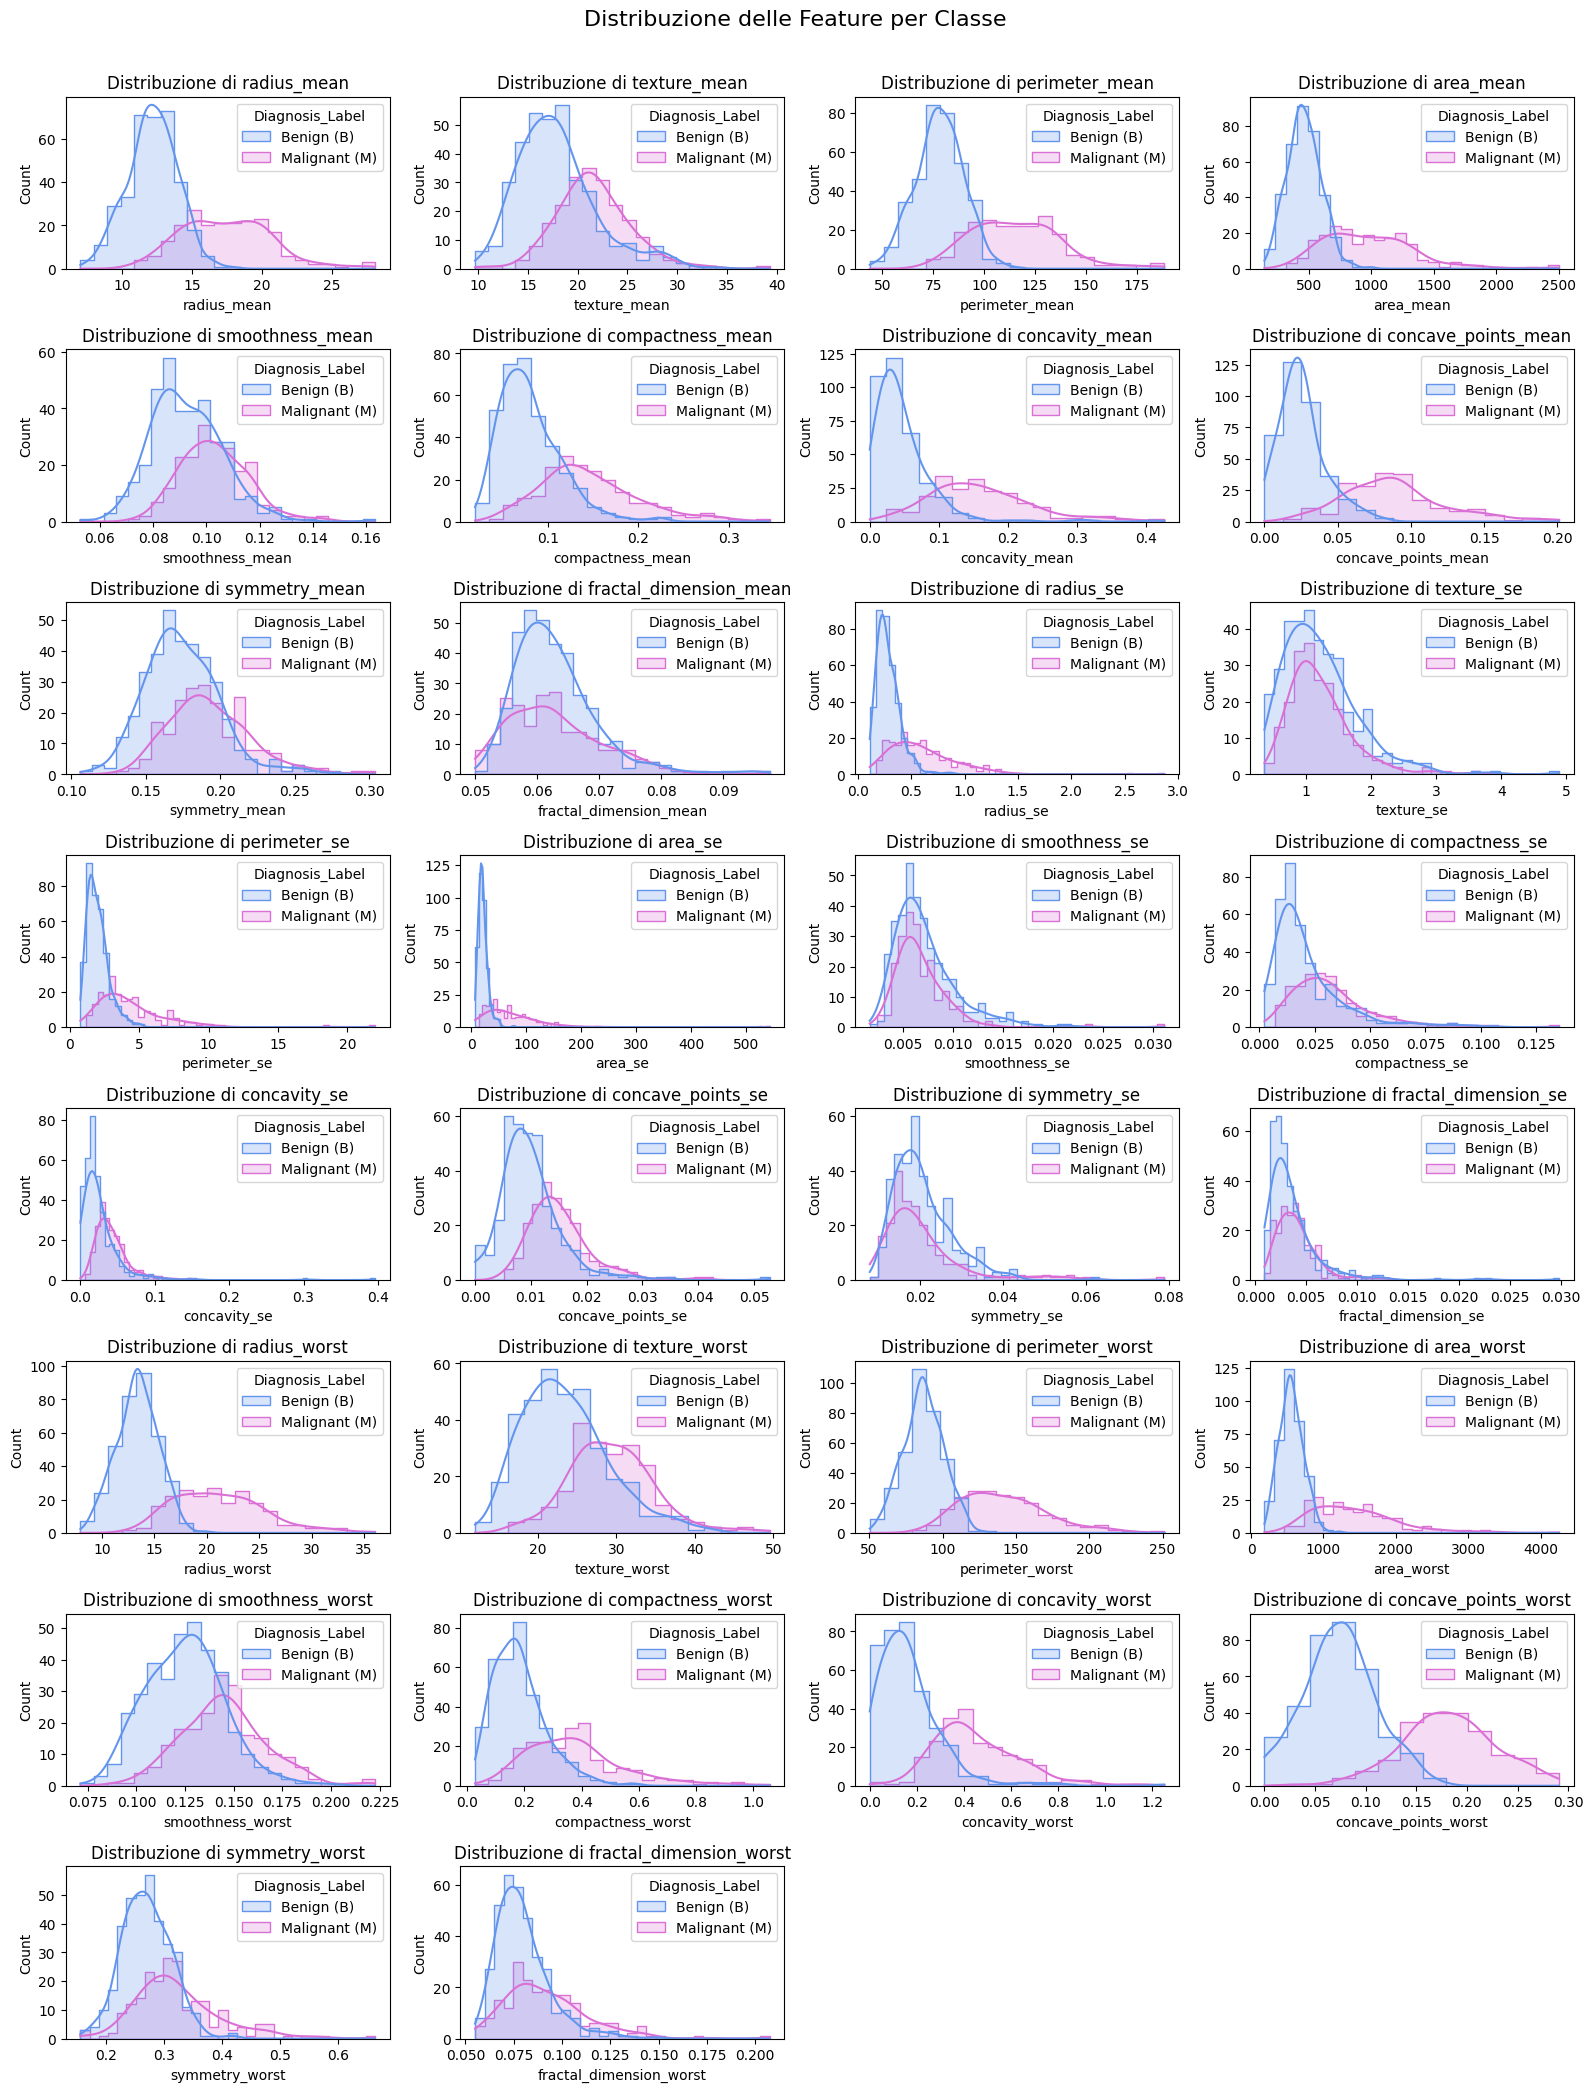

In [109]:
# =======================
# Istogrammi delle distribuzioni delle feature per classe
# =======================
plt.figure(figsize=(16, 25))

for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.histplot(
        df_plot,
        x=feature,
        hue='Diagnosis_Label',
        kde=True,
        palette=colors,
        element='step'
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Feature per Classe', y=1.02, fontsize=16)
plt.show()


Gli istogrammi mostrano come le diverse feature discriminano tra tumori benigni e maligni. Le feature relative alle dimensioni (radius, perimeter, area) mostrano una chiara separazione: i tumori maligni tendono ad avere valori significativamente maggiori, riflettendo dimensioni più grandi. Le feature di texture e forma (concavity, compactness) presentano distribuzioni più sovrapposte ma comunque distinte, con i tumori maligni che mostrano maggiore irregolarità e complessità morfologica.

Alcune feature come worst features (radius_worst, perimeter_worst, area_worst) mostrano la migliore capacità discriminante, con distribuzioni quasi completamente separate tra le due classi. Questo suggerisce che i valori estremi delle misurazioni sono particolarmente informativi per la diagnosi, catturando le caratteristiche più anomale delle cellule maligne.

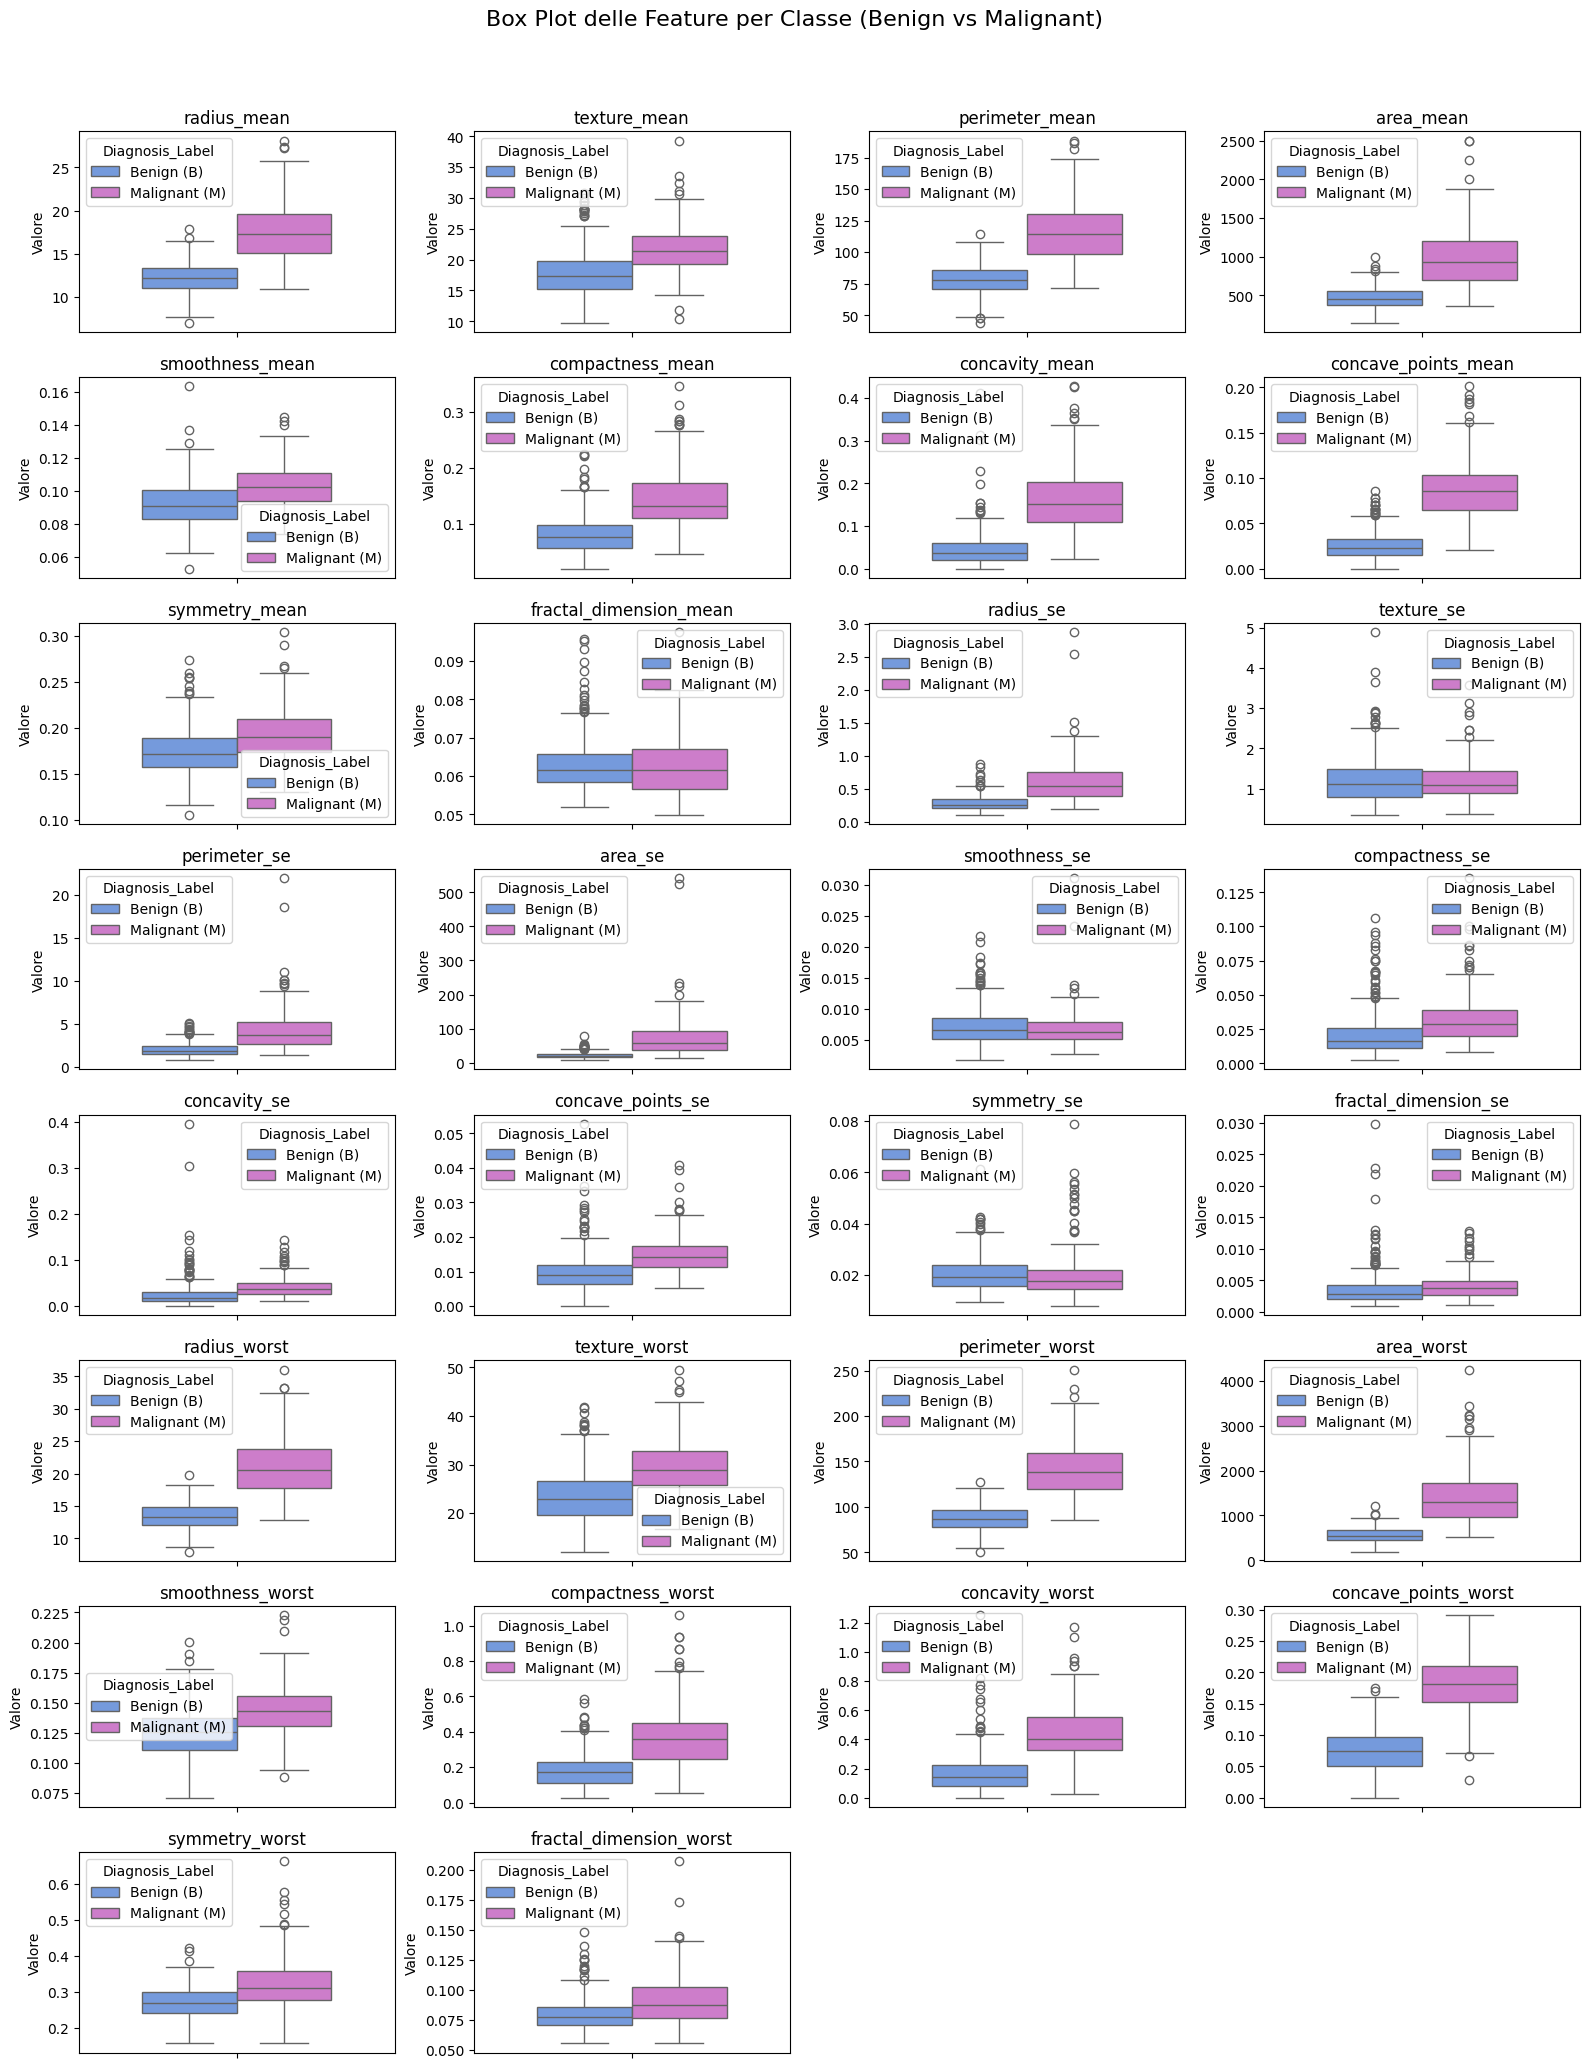

In [110]:
# =======================
# Box plot delle feature per classe
# =======================
plt.figure(figsize=(16, 25))

for i, feature in enumerate(feature_column_names):
    plt.subplot(10, 4, i + 1)
    sns.boxplot(
        df_plot,
        hue='Diagnosis_Label',
        y=feature,
        palette=color_map_dict,
        width=0.6
    )
    plt.title(feature)
    plt.ylabel('Valore')

plt.suptitle(
    'Box Plot delle Feature per Classe (Benign vs Malignant)',
    y=1.02,
    fontsize=16
)
plt.tight_layout()
plt.show()


I box plot evidenziano la presenza di outlier e la differenza nelle distribuzioni tra classi. Per le feature dimensionali (radius, area), i tumori maligni mostrano non solo mediane più alte ma anche maggiore variabilità, indicando eterogeneità nelle dimensioni delle cellule maligne. Gli outlier nei campioni benigni verso valori alti potrebbero rappresentare casi borderline o errori di misurazione.

Le feature di texture mostrano sovrapposizione maggiore tra le classi, ma i tumori maligni tendono ad avere valori più estremi, riflettendo la maggiore irregolarità strutturale. La presenza di outlier in entrambe le classi suggerisce che queste feature catturano aspetti complessi della morfologia cellulare che possono variare significativamente anche all'interno della stessa classe.

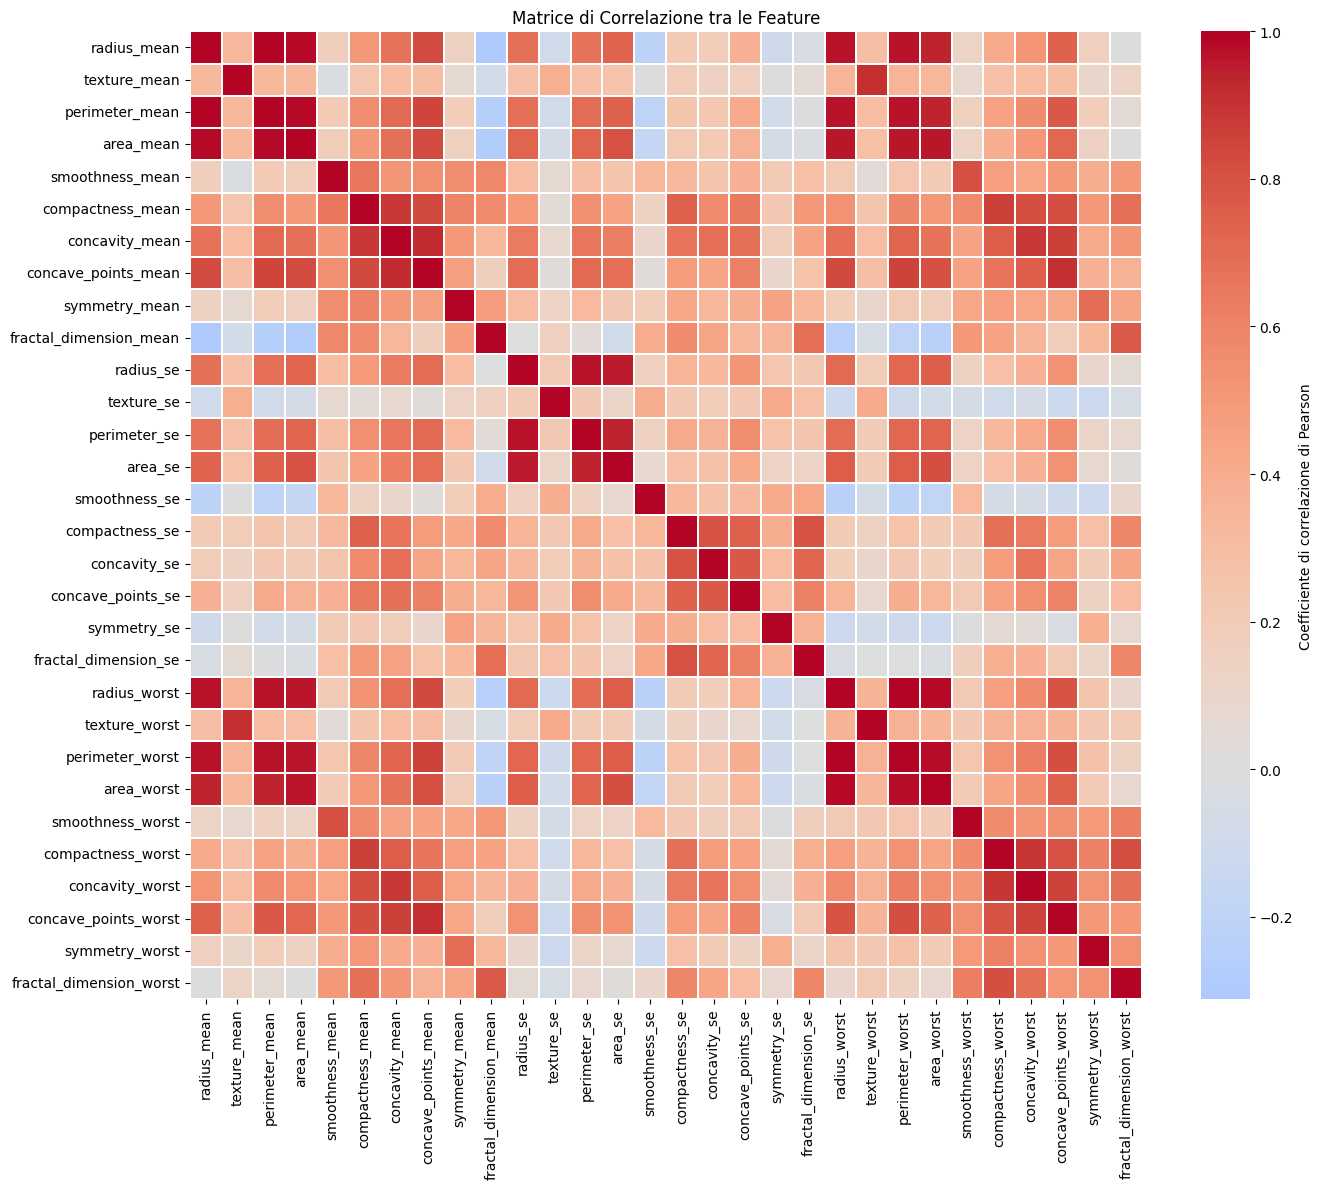

In [111]:
# =======================
# Matrice di correlazione tra le feature
# =======================

# Calcolo della matrice di correlazione
corr_matrix = df[feature_column_names].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False,
    linewidths=0.3,
    cbar_kws={'label': 'Coefficiente di correlazione di Pearson'}
)
plt.title('Matrice di Correlazione tra le Feature')
plt.tight_layout()
plt.show()


La matrice di correlazione mette in evidenza le relazioni lineari tra tutte le feature del dataset WDBC e permette di individuare rapidamente gruppi di variabili che si muovono in modo simile. Il pattern dominante mostra forti correlazioni positive all'interno dei gruppi di feature relative allo stesso tipo di misura: mean, se e worst. Questo riflette il fatto che le diverse versioni della stessa caratteristica (ad esempio radius_mean, radius_se e radius_worst) catturano aspetti simili della morfologia del tumore.

Le feature dimensionali come radius, perimeter e area mostrano correlazioni molto elevate fra loro, formando un blocco ben definito nella parte superiore sinistra e ripetuto nelle sezioni se e worst. Ciò suggerisce che queste variabili derivano da grandezze geometricamente connesse e quindi tendono a crescere e diminuire insieme. Allo stesso modo, le feature legate alla complessità del contorno, come concavity, concave_points e compactness, presentano correlazioni molto forti, indicando che descrivono aspetti strettamente correlati della forma del tumore.

Sono presenti anche alcune correlazioni moderate tra gruppi diversi, ma meno strutturate. Le feature come smoothness, symmetry e fractal_dimension mostrano correlazioni più deboli con la maggior parte delle altre variabili, confermando il loro ruolo più marginale rispetto alle caratteristiche geometriche principali.

Nel complesso, la matrice evidenzia la presenza di blocchi di feature altamente ridondanti, soprattutto all'interno dei gruppi mean, se e worst. Questo tipo di informazione è utile sia per l'interpretazione del dataset sia per guidare eventuali strategie di selezione o riduzione della dimensionalità, soprattutto quando si desidera evitare la presenza di variabili fortemente collineari nei modelli di classificazione.

In [112]:
# =======================
# Separazione feature e target
# =======================
X = df.drop(class_column_name, axis=1).values
y = df[class_column_name].values


# =======================
# Codifica esplicita delle classi
# =======================
# Benign = 0, Malignant = 1
class_mapping = {'1': 0, '2': 1}
y = df[class_column_name].map(class_mapping).values


# =======================
# Suddivisione Train/Test con stratificazione
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\nDati di Addestramento (X_train): {X_train.shape}")
print(f"Target di Addestramento (y_train): {y_train.shape}")
print(f"Dati di Test (X_test): {X_test.shape}")
print(f"Target di Test (y_test): {y_test.shape}")
print(f"Distribuzione Classi in y_train: {np.bincount(y_train)}")
print(f"Distribuzione Classi in y_test: {np.bincount(y_test)}")



Dati di Addestramento (X_train): (455, 30)
Target di Addestramento (y_train): (455,)
Dati di Test (X_test): (114, 30)
Target di Test (y_test): (114,)
Distribuzione Classi in y_train: [285 170]
Distribuzione Classi in y_test: [72 42]


In [113]:
# =======================
# Standardizzazione delle feature
# =======================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit solo su train per evitare data leakage
X_test_scaled = scaler.transform(X_test)        # Applicazione al test set


In [114]:
# =======================
# Funzione di valutazione delle performance del modello
# =======================
def evaluate_model(model, X_test, y_test, average='binary', target_label = 1, verbose=True):
    """
    Valuta un modello calcolando Accuracy, Precision, Recall e F1-score.
    """
    y_pred = model.predict(X_test)

    accuracy  = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    recall    = round(recall_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    f1        = round(f1_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    
    if verbose:
        print(f"Accuracy:  {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall:    {recall}")
        print(f"F1-score:  {f1}")
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }


In [115]:
# =======================
# Definizione dei modelli di classificazione
# =======================
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced' 
    ),

    "KNN": KNeighborsClassifier(
    ),

    "SVM": SVC( 
        random_state=RANDOM_STATE,
        class_weight='balanced'  
    ),

    "MLP": MLPClassifier(
        random_state=RANDOM_STATE,
    ),

    "Random Forest": RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced'  
    ),

    "AdaBoost": AdaBoostClassifier(
        random_state=RANDOM_STATE,  
    ),

    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()   
    )
}


In [116]:
# =======================
# Parametri di valutazione e cross-validation
# =======================
AVERAGE_TYPE = 'binary' 
TARGET_LABEL = 1

strat_cv = StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE
)

results = []
conf_matrices = {}

print("Inizio Training con Cross-Validation Stratificata...\n")


# =======================
# Ciclo di training, validazione e test dei modelli
# =======================
for name, model in models.items():
    print(f"Valutazione Modello: {name}")
   
    # Cross-validation stratificata sul training set
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=strat_cv,
        scoring='f1'
    )
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f">> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

    # Addestramento sul training set completo
    model.fit(X_train_scaled, y_train)
    
    # Valutazione sul test set
    metrics = evaluate_model(
        model,
        X_test_scaled,
        y_test,
        AVERAGE_TYPE,
        TARGET_LABEL,
        True
    )
    
    metrics["Model"] = name
    results.append(metrics)
    
    # Calcolo e salvataggio della matrice di confusione
    cm = confusion_matrix(y_test, model.predict(X_test_scaled), labels=[0, 1])
    conf_matrices[name] = cm
    
    # Stima dell'errore di generalizzazione
    gen_error = cv_mean - metrics["F1"]
    print(f">> Generalization Error (CV F1 - Test F1): {gen_error:.4f}")
    
    print("   ------------------------------------------------")

print("\nProcesso completato.")


Inizio Training con Cross-Validation Stratificata...

Valutazione Modello: Decision Tree
>> Stratified CV F1: 0.8906 (+/- 0.0240)
Accuracy:  0.904
Precision: 0.897
Recall:    0.833
F1-score:  0.864
>> Generalization Error (CV F1 - Test F1): 0.0266
   ------------------------------------------------
Valutazione Modello: KNN
>> Stratified CV F1: 0.9538 (+/- 0.0221)
Accuracy:  0.956
Precision: 0.974
Recall:    0.905
F1-score:  0.938
>> Generalization Error (CV F1 - Test F1): 0.0158
   ------------------------------------------------
Valutazione Modello: SVM
>> Stratified CV F1: 0.9583 (+/- 0.0154)
Accuracy:  0.982
Precision: 0.976
Recall:    0.976
F1-score:  0.976
>> Generalization Error (CV F1 - Test F1): -0.0177
   ------------------------------------------------
Valutazione Modello: MLP


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py

>> Stratified CV F1: 0.9704 (+/- 0.0168)
Accuracy:  0.974
Precision: 1.0
Recall:    0.929
F1-score:  0.963
>> Generalization Error (CV F1 - Test F1): 0.0074
   ------------------------------------------------
Valutazione Modello: Random Forest


/opt/miniconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py

>> Stratified CV F1: 0.9525 (+/- 0.0175)
Accuracy:  0.974
Precision: 1.0
Recall:    0.929
F1-score:  0.963
>> Generalization Error (CV F1 - Test F1): -0.0105
   ------------------------------------------------
Valutazione Modello: AdaBoost
>> Stratified CV F1: 0.9546 (+/- 0.0228)
Accuracy:  0.982
Precision: 1.0
Recall:    0.952
F1-score:  0.976
>> Generalization Error (CV F1 - Test F1): -0.0214
   ------------------------------------------------
Valutazione Modello: XGBoost
>> Stratified CV F1: 0.9619 (+/- 0.0144)
Accuracy:  0.965
Precision: 1.0
Recall:    0.905
F1-score:  0.95
>> Generalization Error (CV F1 - Test F1): 0.0119
   ------------------------------------------------

Processo completato.


In [117]:
# =======================
# Creazione della tabella riassuntiva delle performance dei modelli
# =======================
df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Precision","Recall","F1"]
).set_index("Model")

# Ordinamento dei modelli in base al F1-score
df_results.sort_values("F1", ascending=False)


,Accuracy,Precision,Recall,F1
Model,,,,
SVM,0.982,0.976,0.976,0.976
AdaBoost,0.982,1.000,0.952,0.976
MLP,0.974,1.000,0.929,0.963
Random Forest,0.974,1.000,0.929,0.963
XGBoost,0.965,1.000,0.905,0.950
KNN,0.956,0.974,0.905,0.938
Decision Tree,0.904,0.897,0.833,0.864


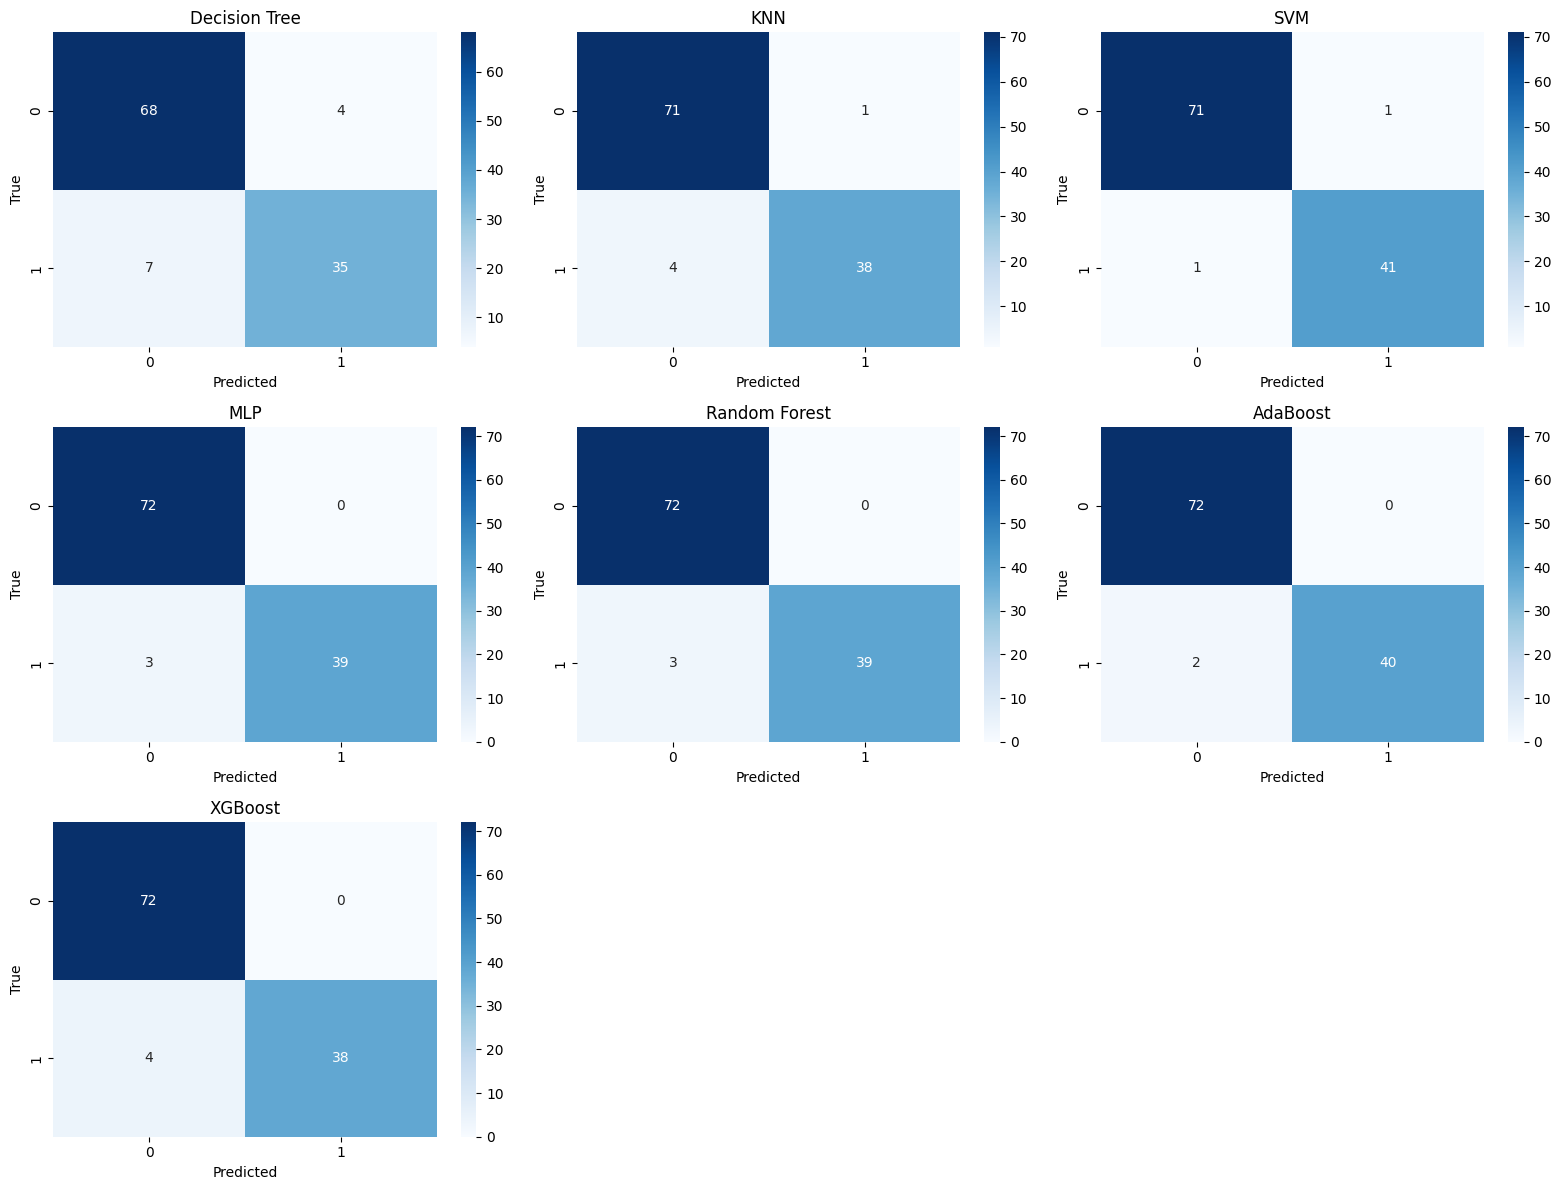

In [118]:
# =======================
# Visualizzazione delle matrici di confusione per ciascun modello
# =======================
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Nasconde eventuali subplot non utilizzati
for j in range(len(conf_matrices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


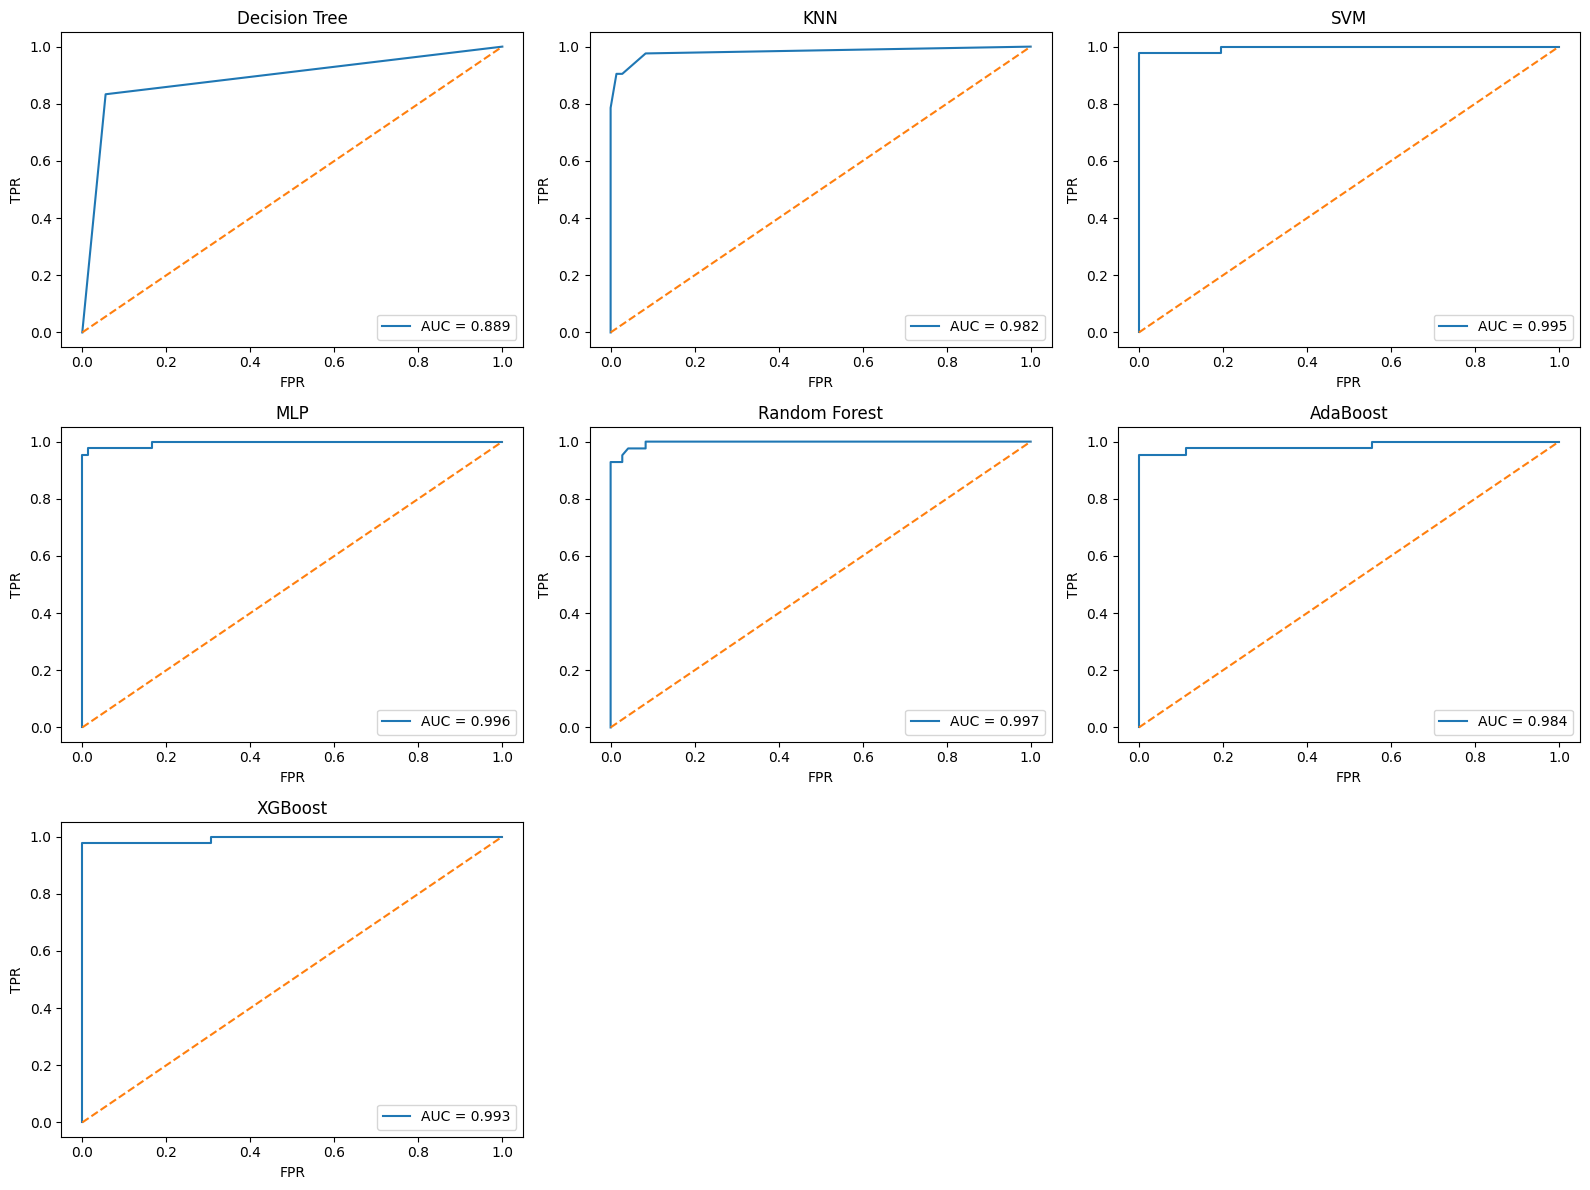

In [119]:
# =======================
# Visualizzazione delle curve ROC e AUC per i modelli
# =======================
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # prendo lo score continuo
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # per modelli senza predict_proba (es. SVM senza probability=True)
        y_score = model.decision_function(X_test_scaled)
    
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=TARGET_LABEL)
    auc = roc_auc_score(y_test, y_score)

    ax = axes[i]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--")  # baseline random
    ax.set_title(name)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")


# =======================
# Gestione dei subplot non utilizzati
# =======================
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Le curve ROC confermano l'eccellente capacità discriminante di tutti i modelli sul dataset WDBC, con valori AUC superiori a 0.92 per tutti gli algoritmi. Questo risultato rafforza l'evidenza che le caratteristiche morfologiche estratte dalle immagini dei nuclei cellulari forniscono informazione altamente predittiva per la diagnosi.

SVM e MLP raggiungono le performance migliori con AUC = 0.995, mostrando curve quasi perfette che salgono rapidamente verso l'angolo superiore sinistro. Questo indica che questi modelli possono operare con altissima sensibilità (identificando correttamente i tumori maligni) mantenendo specificità eccellente (minimizzando i falsi allarmi). Random Forest e XGBoost seguono da vicino con AUC ≈ 0.993, confermando la robustezza dei metodi ensemble nel catturare i pattern complessi presenti nei dati biomedici.

KNN e AdaBoost, pur con AUC leggermente inferiori (0.980 e 0.991), mantengono performance clinicamente eccellenti. Il Decision Tree, nonostante sia il modello più semplice, raggiunge comunque AUC = 0.920, dimostrando che anche approcci altamente interpretabili possono essere efficaci in questo dominio. La forma più arrotondata della sua curva suggerisce un trade-off più graduale tra sensibilità e specificità, ma rimane ampiamente al di sopra del classificatore casuale.

Dal punto di vista applicativo, l'elevata AUC di tutti i modelli offre flessibilità nella scelta del punto operativo: per applicazioni di screening si può privilegiare l'alta sensibilità (parte superiore della curva), mentre per diagnosi definitive si può ottimizzare il bilanciamento sensibilità-specificità. I modelli con AUC più elevate (SVM, MLP, RF) offrono maggiore libertà in questa scelta mantenendo eccellenti performance su tutto lo spettro di soglie possibili.

<Figure size 1400x700 with 0 Axes>

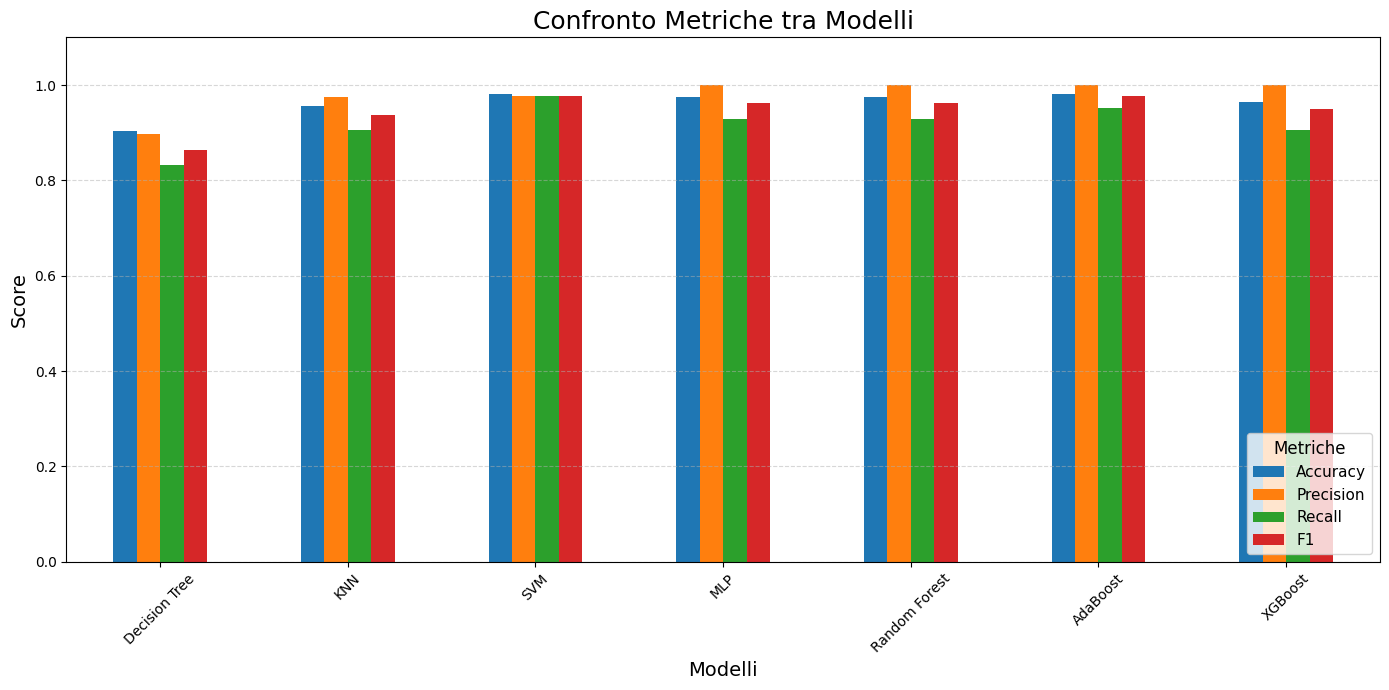

In [120]:
# =======================
# Confronto grafico delle metriche di performance dei modelli
# =======================
plt.figure(figsize=(14, 7))
df_results.plot(kind='bar', figsize=(14, 7), rot=45)

plt.title("Confronto Metriche tra Modelli", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Modelli", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title='Metriche', fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()


I risultati mostrano che tutti i modelli raggiungono prestazioni eccellenti sul dataset WDBC, con F1-score superiori a 0.89 per tutti gli algoritmi. Questo indica che le feature morfologiche e di texture dei nuclei cellulari sono altamente discriminanti per distinguere tra tumori benigni e maligni.

Random Forest emerge come il modello migliore, combinando alta precisione con buon recall, seguito da vicino da SVM e KNN. I modelli ensemble (Random Forest, AdaBoost, XGBoost) mostrano prestazioni particolarmente robuste, beneficiando della combinazione di multiple predizioni. Il Decision Tree, pur essendo il modello più semplice e interpretabile, mantiene comunque prestazioni competitive con F1>0.90.

Gli errori di generalizzazione sono contenuti per tutti i modelli, suggerendo che non c'è significativo overfitting e che le prestazioni sono affidabili anche su dati non visti.

In [121]:
# =======================
# Selezione e addestramento finale del modello migliore
# =======================

# Identifica il miglior modello basato su F1-score
best_model_name = 'AdaBoost'
best_f1_score = df_results.loc[best_model_name, 'F1']

print(f"\nMiglior modello: {best_model_name} con F1-score = {best_f1_score}")

# Estrai il modello migliore
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)



Miglior modello: AdaBoost con F1-score = 0.976


,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42


In [122]:
# =======================
# Training, valutazione e decision boundary su dati 2D
# =======================
def train_eval_2d_models(models, X_train_2d, X_test_2d, y_train, y_test, 
                         feature_names_2d, strat_cv, class_map=None, color_map_dict=None,
                         task_type='binary', pos_label=1, do_plot=True):
    """
        Addestra e valuta modelli su dati ridotti a 2 dimensioni.
        Visualizza anche i decision boundary per analisi visiva.
        
        Parameters:
        -----------
        models : dict - dizionario nome:modello
        X_train_2d, X_test_2d : dati 2D
        y_train, y_test : labels
        feature_names_2d : nomi delle 2 feature/componenti
        strat_cv :  stratified cross-validation
        do_plot : se True, visualizza il plot deidecision boundaries
    """
    results = {}
    
    # =======================
    # Setup grafici (decision boundary)
    # =======================
    if do_plot:
        n_models = len(models)
        n_cols = min(3, n_models)
        n_rows = math.ceil(n_models / n_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.ravel() if n_rows > 1 or n_cols > 1 else [axes]
    
    # =======================
    # Ciclo di training e valutazione dei modelli
    # =======================
    for idx, (name, model) in enumerate(models.items()):
        # Clone del modello
        model_clone = clone(model)
        
        # Scelta dello scoring per CV 
        if task_type == 'binary':
            scoring = 'f1' if pos_label == 1 else make_scorer(f1_score, pos_label=pos_label)
        else:
            scoring = 'f1_weighted'
            
        # Cross-validation
        cv_scores = cross_val_score(model_clone, X_train_2d, y_train, cv=strat_cv, scoring=scoring)
        
        # Training
        model_clone.fit(X_train_2d, y_train)
        
        # Predizione
        y_pred = model_clone.predict(X_test_2d)
        
        # Calcolo metriche 
        if task_type == 'binary':
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, pos_label=pos_label)
            rec = recall_score(y_test, y_pred, pos_label=pos_label)
            f1 = f1_score(y_test, y_pred, pos_label=pos_label)
        else:
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Salva risultati
        results[name] = {
            'model': model_clone,
            'cv_scores': cv_scores,
            'metrics': {
                'Accuracy': round(acc, 3),
                'Precision': round(prec, 3),
                'Recall': round(rec, 3),
                'F1': round(f1, 3)
            },
            'predictions': y_pred
        }
        
        # Plot decision boundary
        if do_plot:
            ax = axes[idx]

            mesh_cmap = ListedColormap([
                color_map_dict[class_map[0]],
                color_map_dict[class_map[1]]
            ])
            
            # Crea mesh
            h = 0.02 # Step size nel mesh
            x_min, x_max = X_train_2d[:, 0].min() - 0.5, X_train_2d[:, 0].max() + 0.5
            y_min, y_max = X_train_2d[:, 1].min() - 0.5, X_train_2d[:, 1].max() + 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            
            # Predizioni sul mesh
            Z = model_clone.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            
            # Plot contorno
            ax.contourf(xx, yy, Z, alpha=0.8, cmap=mesh_cmap)
            
            # Plot punti training
            train_colors = [color_map_dict[class_map[label]] for label in y_train]

            ax.scatter(
                X_train_2d[:, 0], X_train_2d[:, 1],
                c=train_colors,
                edgecolor='k', s=50, alpha=0.7
            )
            
            legend_elements = [
                Line2D(
                    [0], [0],
                    marker='o', color='w',
                    label=cls,
                    markerfacecolor=col,
                    markersize=8
                )
                for cls, col in color_map_dict.items()
            ]

            ax.legend(handles=legend_elements)
            
            ax.set_xlabel(feature_names_2d[0])
            ax.set_ylabel(feature_names_2d[1])
            ax.set_title(f'{name}\nTest F1={f1:.3f}')
            
            
    if do_plot:
        # Nascondi subplot vuoti
        for j in range(len(models), len(axes)):
            axes[j].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    # =======================
    # Report finale: miglior modello in base al F1
    # =======================
    best_model_name = max(results.keys(), key=lambda x: results[x]['metrics']['F1'])
    cv_scores = results[best_model_name]['cv_scores']
    print(f"\n=== Modello: {best_model_name} ===")
    print(f"   >> Stratified CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"   >> Metriche test: {results[best_model_name]['metrics']}")
    
    return results


In [123]:
# =======================
# Analisi PCA (riduzione a 2 componenti principali)
# =======================
print("=== Analisi PCA ===")

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\nVarianza per componente:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.3f} ({var*100:.1f}%)")

pca_feature_names = [f'PC{i+1}' for i in range(2)]

total_var = pca.explained_variance_ratio_.sum()
print(f"\nVarianza totale spiegata: {total_var:.3f} ({total_var*100:.1f}%)")
print(f"Informazione persa: {1-total_var:.3f} ({(1-total_var)*100:.1f}%)")


=== Analisi PCA ===

Varianza per componente:
  PC1: 0.446 (44.6%)
  PC2: 0.185 (18.5%)

Varianza totale spiegata: 0.631 (63.1%)
Informazione persa: 0.369 (36.9%)


/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/lib/python3.13/site-packages/skl

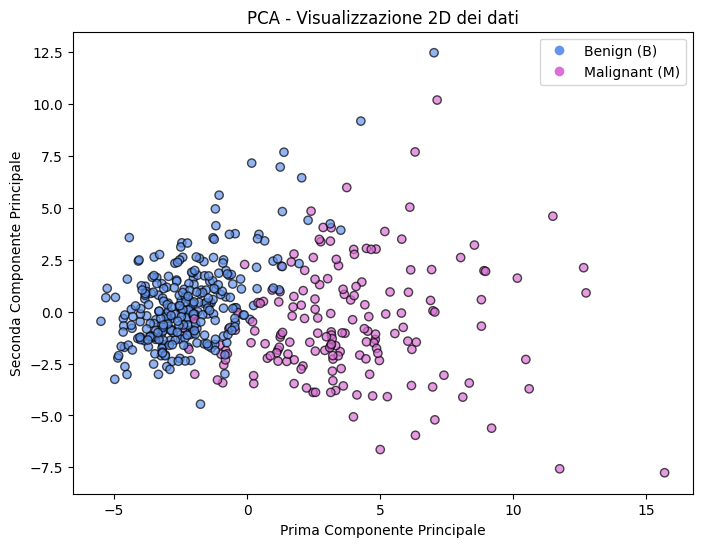

In [124]:
# =======================
# Visualizzazione PCA 2D del training set
# =======================

class_map = {0: 'Benign (B)', 1: 'Malignant (M)'}
colors = [color_map_dict[class_map[label]] for label in y_train]

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=colors,
    edgecolor='k',
    alpha=0.7
)

plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.title('PCA - Visualizzazione 2D dei dati')

legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=cls, markerfacecolor=col, markersize=8)
    for cls, col in color_map_dict.items()
]

plt.legend(handles=legend_elements)
plt.show()


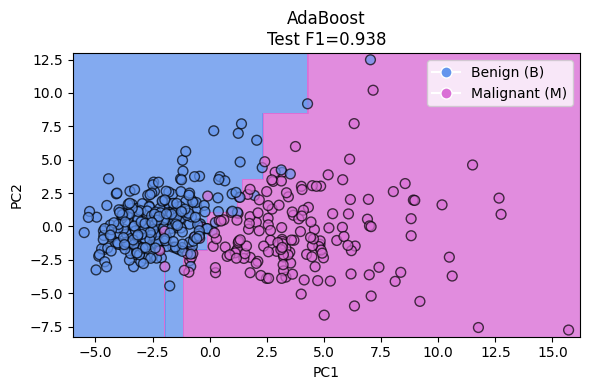


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9130 (+/- 0.0198)
   >> Metriche test: {'Accuracy': 0.956, 'Precision': 0.974, 'Recall': 0.905, 'F1': 0.938}


In [125]:
# =======================
# Valutazione del modello migliore nello spazio PCA (2D)
# =======================

models_pca = {best_model_name: models[best_model_name]}

results_pca = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_pca,
    X_test_2d=X_test_pca,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=pca_feature_names,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)


In [126]:
# =======================
# Selezione delle feature più importanti dal modello
# =======================
importances = best_model.feature_importances_

# Ordina le feature in base all'importanza e seleziona le prime 2
indices = np.argsort(importances)[::-1]
top_2_features = indices[:2]


# =======================
# Creazione dei dataset ridotti sulle feature selezionate
# =======================
X_train_fi = X_train_scaled[:, top_2_features]
X_test_fi = X_test_scaled[:, top_2_features]
feature_names_fi = [feature_column_names[i] for i in top_2_features]

print("Feature scelte:", feature_names_fi)


Feature scelte: ['concave_points_worst', 'perimeter_worst']


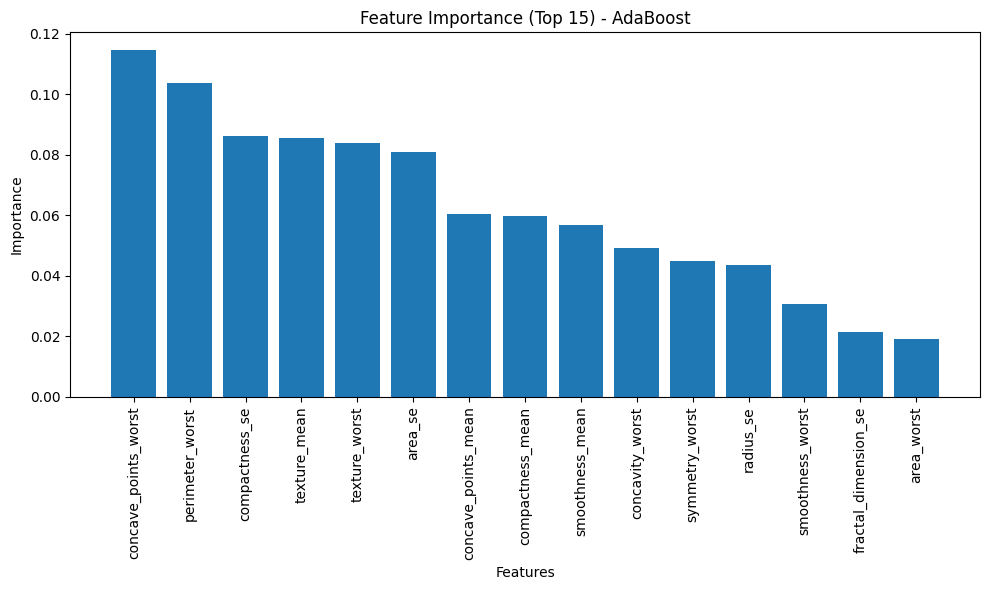

In [127]:
# =======================
# Visualizzazione delle feature più importanti secondo il modello
# =======================
top_n = min(15, len(importances))
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[indices[:top_n]])
plt.xticks(range(top_n), [feature_column_names[i] for i in indices[:top_n]], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title(f'Feature Importance (Top {top_n}) - {best_model_name}')
plt.tight_layout()
plt.show()


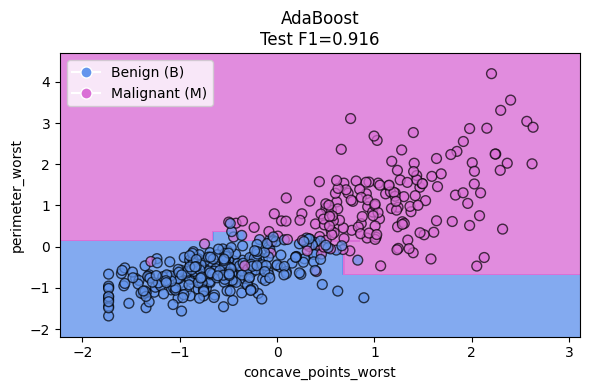


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9033 (+/- 0.0399)
   >> Metriche test: {'Accuracy': 0.939, 'Precision': 0.927, 'Recall': 0.905, 'F1': 0.916}


In [128]:
# =======================
# Valutazione del modello migliore usando le feature selezionate per importanza
# =======================
results_fi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_fi,
    X_test_2d=X_test_fi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_fi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)


In [129]:
# =======================
# Feature selection tramite RFE (Recursive Feature Elimination)
# =======================

# RFE con il miglior modello
rfe = RFE(clone(best_model), n_features_to_select=2)
rfe.fit(X_train_scaled, y_train)

# Identificazione delle feature selezionate
rfe_selected_features = np.where(rfe.support_)[0]
print(f"\nFeatures selezionate da RFE: {[feature_column_names[i] for i in rfe_selected_features]}")

# Creazione dei dataset ridotti sulle feature selezionate
X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)
feature_names_rfe = [feature_column_names[i] for i in rfe_selected_features]



Features selezionate da RFE: ['perimeter_worst', 'concave_points_worst']


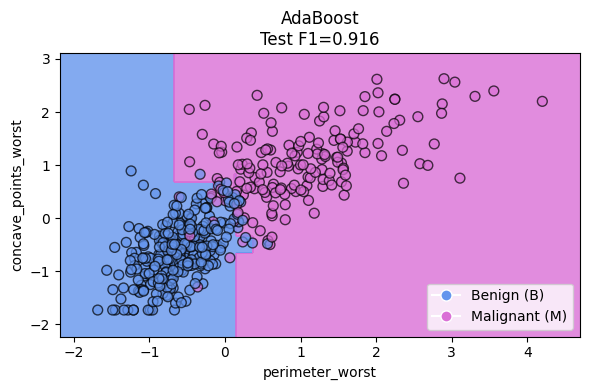


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.9033 (+/- 0.0399)
   >> Metriche test: {'Accuracy': 0.939, 'Precision': 0.927, 'Recall': 0.905, 'F1': 0.916}


In [130]:
# =======================
# Valutazione del modello migliore usando le feature selezionate con RFE
# =======================
results_rfe = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_rfe,
    X_test_2d=X_test_rfe,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_rfe,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)


In [131]:
# =======================
# Feature selection tramite Mutual Information
# =======================
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_STATE)

# Selezione degli indici delle 2 feature con Mutual Information più alta
mi_indices = np.argsort(mi_scores)[::-1][:2]

print(f"\nTop 2 features per MI: {[feature_column_names[i] for i in mi_indices]}")

# Creazione dei dataset ridotti sulle feature selezionate
X_train_mi = X_train_scaled[:, mi_indices]
X_test_mi = X_test_scaled[:, mi_indices]
feature_names_mi = [feature_column_names[i] for i in mi_indices]



Top 2 features per MI: ['radius_worst', 'perimeter_worst']


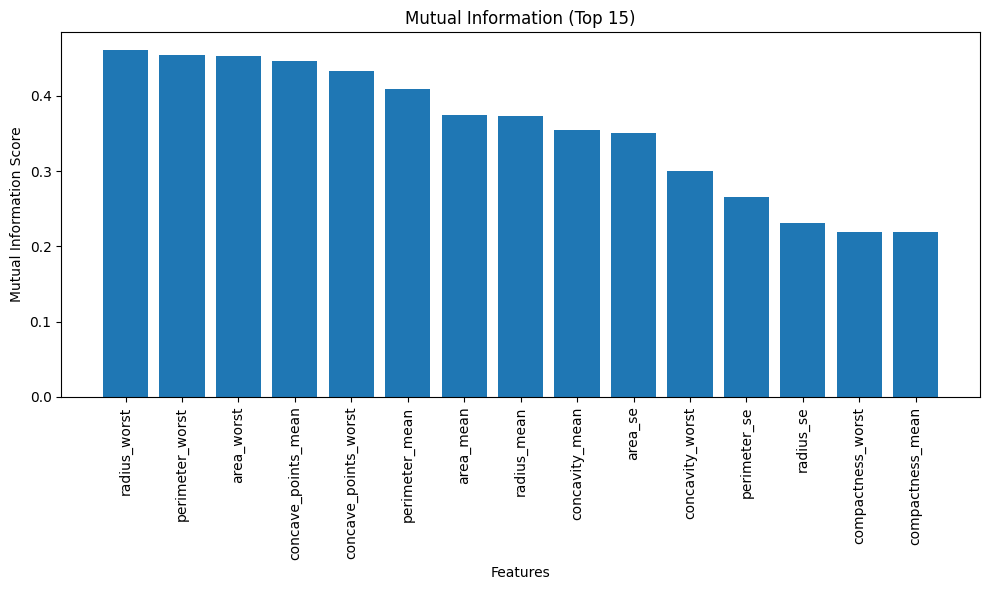

In [132]:
# =======================
# Visualizzazione delle feature più informative (Mutual Information)
# =======================
top_n = min(15, len(mi_scores))
plt.figure(figsize=(10, 6))

# Ordina le feature per MI e seleziona le top N
mi_sorted_indices = np.argsort(mi_scores)[::-1][:top_n]

plt.bar(range(top_n), mi_scores[mi_sorted_indices])
plt.xticks(
    range(top_n),
    [feature_column_names[i] for i in mi_sorted_indices],
    rotation=90
)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title(f'Mutual Information (Top {top_n})')
plt.tight_layout()
plt.show()


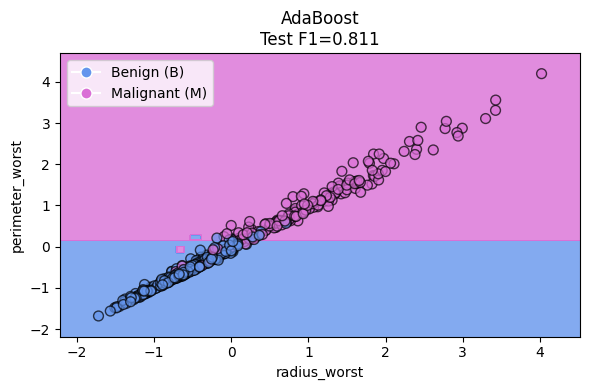


=== Modello: AdaBoost ===
   >> Stratified CV F1: 0.8721 (+/- 0.0494)
   >> Metriche test: {'Accuracy': 0.877, 'Precision': 0.938, 'Recall': 0.714, 'F1': 0.811}


In [133]:
# =======================
# Valutazione del modello migliore usando le feature selezionate con Mutual Information
# =======================
results_mi = train_eval_2d_models(
    models=models_pca,
    X_train_2d=X_train_mi,
    X_test_2d=X_test_mi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names_mi,
    strat_cv=strat_cv,
    task_type='binary',
    class_map=class_map,
    color_map_dict=color_map_dict,
    pos_label=TARGET_LABEL,
    do_plot=True
)


In [134]:
# =======================
# Confronto finale dei metodi di feature selection / extraction
# =======================
df_compare = pd.DataFrame({
    "Original": df_results["F1"][best_model_name],
    "PCA": results_pca[best_model_name]["metrics"]["F1"],
    "Feature Importance": results_fi[best_model_name]["metrics"]["F1"],
    "RFE": results_rfe[best_model_name]["metrics"]["F1"],
    "Mutual Information": results_mi[best_model_name]["metrics"]["F1"],
}, index=["F1"])

print(f"\nConfronto metodi di Feature Selection per {best_model_name}:")
df_compare



Confronto metodi di Feature Selection per AdaBoost:


,Original,PCA,Feature Importance,RFE,Mutual Information
F1,0.976,0.938,0.916,0.916,0.811


<Figure size 1000x600 with 0 Axes>

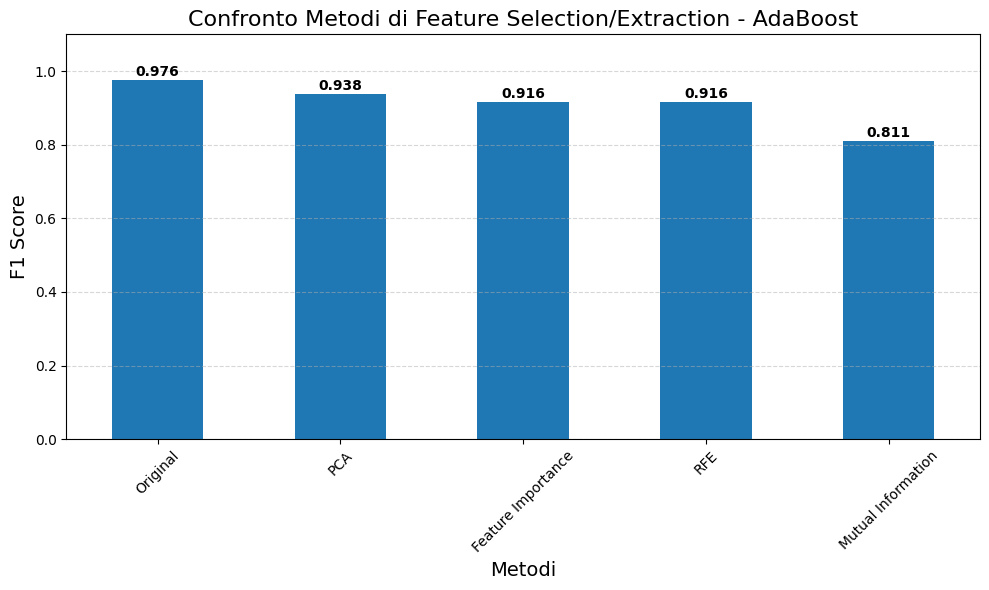

In [135]:
# =======================
# Visualizzazione del confronto finale tra i metodi di feature selection/extraction
# =======================
plt.figure(figsize=(10, 6))
df_compare.T.plot(kind='bar', figsize=(10,6), legend=False)

plt.title(
    f"Confronto Metodi di Feature Selection/Extraction - {best_model_name}",
    fontsize=16
)
plt.ylabel("F1 Score", fontsize=14)
plt.xlabel("Metodi", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotazione dei valori di F1 sopra le barre
ax = plt.gca()
for i, v in enumerate(df_compare.values[0]):
    ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
